# TensorFlow script mode training and serving

Script mode is a training script format for TensorFlow that lets you execute any TensorFlow training script in SageMaker with minimal modification. The [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) handles transferring your script to a SageMaker training instance. On the training instance, SageMaker's native TensorFlow support sets up training-related environment variables and executes your training script. In this tutorial, we use the SageMaker Python SDK to launch a training job and deploy the trained model.

Script mode supports training with a Python script, a Python module, or a shell script. In this example, we use a Python script to train a classification model on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). In this example, we will show how easily you can train a SageMaker using TensorFlow 1.x and TensorFlow 2.0 scripts with SageMaker Python SDK. In addition, this notebook demonstrates how to perform real time inference with the [SageMaker TensorFlow Serving container](https://github.com/aws/sagemaker-tensorflow-serving-container). The TensorFlow Serving container is the default inference method for script mode. For full documentation on the TensorFlow Serving container, please visit [here](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/deploying_tensorflow_serving.rst).


1. You will first define the problem you want to solve and investigate potential solutions.
2. Next, you will analyze the problem through visualizations and data exploration to have a better understanding of what algorithms and features are appropriate for solving it.
3.You will then implement your algorithms and metrics of choice, documenting the preprocessing, refinement, and post-processing steps along the way.
4. Afterwards, you will collect results about your findings, visualize significant quantities, validate/justify your results, and make any concluding remarks about whether your implementation adequately solves the problem.
5. Finally, you will construct a blog post to document all of the steps from start to finish of your project, or deploy your results into a web application.

# Set up the environment

Let's start by setting up the environment:

In [25]:
!python3 -m pip install -U pip && python3 -m pip install -r source/requirements.txt --quiet

  Using cached pip-21.0-py3-none-any.whl (1.5 MB)
     |████████████████████████████████| 1.5 MB 19.1 MB/s eta 0:00:01


In [26]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

## Downloading the data
We'll use the images provided in the deep lesion dataset.
"The National Institutes of Health’s Clinical Center has made a large-scale dataset of CT images publicly available to help the scientific community improve detection accuracy of lesions. While most publicly available medical image datasets have less than a thousand lesions, this dataset, named DeepLesion, has over 32,000 annotated lesions identified on CT images, representing 4,400 unique patients"
https://www.nih.gov/news-events/news-releases/nih-clinical-center-releases-dataset-32000-ct-images

In [27]:
from source.utils.preprocessor import DeepLesionPreprocessor
config = {
    'input_path': 'raw_data/',
    'output_path': 'preprocessed_data/',
    'data_urls': ['https://nihcc.box.com/shared/static/l52tpmmkgjlfa065ow8czhivhu5vx27n.zip'],
    'download': True,
    'train': True,
    'test': True,
    'delete_raw': True,
    'crop_size': 128,
    'input_size': 64
}
preprocessor = DeepLesionPreprocessor(config)
preprocessor.run()

477 train files generated
496 train files generated
514 train files generated
521 train files generated
525 train files generated
544 train files generated
560 train files generated
571 train files generated
589 train files generated
604 train files generated
624 train files generated
633 train files generated
652 train files generated
670 train files generated
681 train files generated
689 train files generated
704 train files generated
721 train files generated
741 train files generated
755 train files generated
774 train files generated
780 train files generated
798 train files generated
809 train files generated
819 train files generated
836 train files generated
853 train files generated
862 train files generated
872 train files generated
888 train files generated
899 train files generated
910 train files generated
925 train files generated
944 train files generated
953 train files generated
964 train files generated
977 train files generated
988 train files generated
1003 train f

In [28]:
# create an S3 bucket
bucket = 'sgm-ndmle'

# should be the name of directory you created to save your features data
data_dir = "preprocessed_data/train"

# set prefix, a descriptive name for a directory  
prefix = 'gan_circle'

In [29]:
# upload all data to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix+'/data/train')

In [30]:
training_data_uri = f's3://{bucket}/{prefix}/data'
ckpt_uri = f's3://{bucket}/{prefix}/checkpoint'

In [31]:
training_data_uri

's3://sgm-ndmle/gan_circle/data'

### Explaining the problem

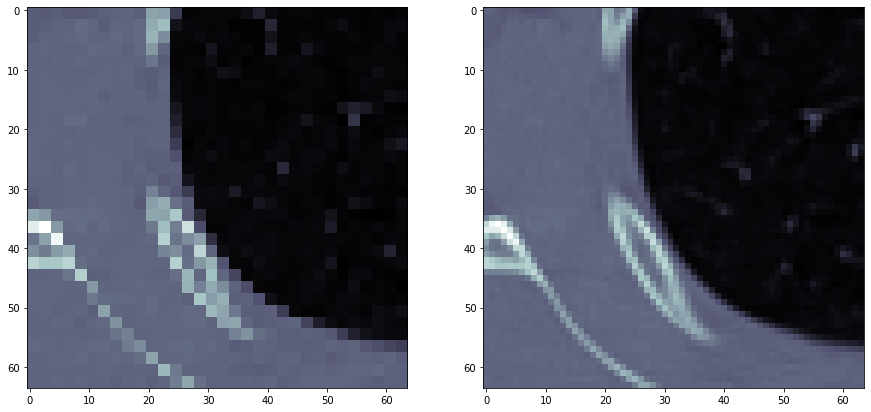

In [32]:
from glob import glob
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import SimpleITK as sitk

files = glob("preprocessed_data/train/*")
file = random.choice(files)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
img = sitk.ReadImage(file)
img = sitk.GetArrayFromImage(img)
img = img * 1. + (-32768)
hu_0 = -10
hu_1 = 400
img = 2. * ((img - (hu_0)) / (hu_1 - (hu_0))) - 1.
img = tf.expand_dims(img, 2)

hr_patch = tf.cast(tf.image.resize(
                img,
                (64, 64),
                method=tf.image.ResizeMethod.BICUBIC,
                preserve_aspect_ratio=True
            ), tf.float32)

lr_patch = tf.cast(tf.image.resize(
                hr_patch,
                (32, 32),
                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
                preserve_aspect_ratio=True
            ), tf.float32)

lr_patch = tf.cast(tf.image.resize(
                lr_patch,
                (64, 64),
                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
                preserve_aspect_ratio=True
            ), tf.float32)


lr_patch = np.squeeze(lr_patch)
axs[0].imshow(lr_patch, cmap=plt.cm.bone)

hr_patch = np.squeeze(hr_patch)
axs[1].imshow(hr_patch, cmap=plt.cm.bone)

# Construct a script for distributed training

This tutorial's training script was adapted from TensorFlow's official [CNN MNIST example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/layers/cnn_mnist.py). We have modified it to handle the ``model_dir`` parameter passed in by SageMaker. This is an S3 path which can be used for data sharing during distributed training and checkpointing and/or model persistence. We have also added an argument-parsing function to handle processing training-related variables.

At the end of the training job we have added a step to export the trained model to the path stored in the environment variable ``SM_MODEL_DIR``, which always points to ``/opt/ml/model``. This is critical because SageMaker uploads all the model artifacts in this folder to S3 at end of training.

Here is the entire script:

In [33]:
# TensorFlow 2.3 script
!pygmentize 'source/train.py'

import tensorflow as tf
import argparse
import os
import numpy as np
import json
from model import ganCIRCLE, generator
from utils.loader import DataLoader


def _parse_args():
    parser = argparse.ArgumentParser()

    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--model_dir', type=str)
    parser.add_argument('--sm-model-dir', type=str,
                        default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str,
                        default=os.environ.get('SM_CHANNEL_TRAINING'))
    parser.add_argument('--hosts', type=list,
                        default=json.loads(os.environ.get('SM_HOSTS')))
    parser.add_argument('--current-host', type=str,
                        default=os.environ.get('SM_CURRENT_HOST'))
    parser.add_argument('--epochs', type=int,
                        default=10)
    parser.add_argument('--batch_s

# Create a training job using the `TensorFlow` estimator

The `sagemaker.tensorflow.TensorFlow` estimator handles locating the script mode container, uploading your script to a S3 location and creating a SageMaker training job. Let's call out a couple important parameters here:

* `py_version` is set to `'py3'` to indicate that we are using script mode since legacy mode supports only Python 2. Though Python 2 will be deprecated soon, you can use script mode with Python 2 by setting `py_version` to `'py2'` and `script_mode` to `True`.

* `distributions` is used to configure the distributed training setup. It's required only if you are doing distributed training either across a cluster of instances or across multiple GPUs. Here we are using parameter servers as the distributed training schema. SageMaker training jobs run on homogeneous clusters. To make parameter server more performant in the SageMaker setup, we run a parameter server on every instance in the cluster, so there is no need to specify the number of parameter servers to launch. Script mode also supports distributed training with [Horovod](https://github.com/horovod/horovod). You can find the full documentation on how to configure `distributions` [here](https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/tensorflow#distributed-training). 



In [36]:
from sagemaker.tensorflow import TensorFlow

circle_estimator = TensorFlow(
     entry_point='train.py',
     role=role,
     source_dir='source',
     train_instance_count=1,
     train_instance_type='ml.m4.xlarge',
     framework_version='2.3.1',
     image_name='763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2.3.1-cpu-py37-ubuntu18.04-v1.12',
     hyperparameters={'epochs': 1, 'checkpoint_folder': ckpt_uri},
    base_job_name='tf-gan-circle'
 )

## Calling ``fit``

To start a training job, we call `estimator.fit(training_data_uri)`.

An S3 location is used here as the input. `fit` creates a default channel named `'training'`, which points to this S3 location. In the training script we can then access the training data from the location stored in `SM_CHANNEL_TRAINING`. `fit` accepts a couple other types of input as well. See the API doc [here](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.EstimatorBase.fit) for details.

When training starts, the TensorFlow container executes mnist.py, passing `hyperparameters` and `model_dir` from the estimator as script arguments. Because we didn't define either in this example, no hyperparameters are passed, and `model_dir` defaults to `s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>`, so the script execution is as follows:
```bash
python mnist.py --model_dir s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>
```
When training is complete, the training job will upload the saved model for TensorFlow serving.

In [ ]:
circle_estimator.fit(training_data_uri)

2021-01-29 13:17:55 Starting - Starting the training job..

# Deploy the trained model to an endpoint

The `deploy()` method creates a SageMaker model, which is then deployed to an endpoint to serve prediction requests in real time. We will use the TensorFlow Serving container for the endpoint, because we trained with script mode. This serving container runs an implementation of a web server that is compatible with SageMaker hosting protocol. The [Using your own inference code]() document explains how SageMaker runs inference containers.

In [ ]:
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName='tf-gan-circle-2021-01-29-04-30-16-539')

model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

In [ ]:
predictor = mnist_estimator.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

# Invoke the endpoint

Let's download the training data and use that as input for inference.

In [ ]:
import numpy as np

!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/train_data.npy train_data.npy
!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/train_labels.npy train_labels.npy

train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')

The formats of the input and the output data correspond directly to the request and response formats of the `Predict` method in the [TensorFlow Serving REST API](https://www.tensorflow.org/serving/api_rest). SageMaker's TensforFlow Serving endpoints can also accept additional input formats that are not part of the TensorFlow REST API, including the simplified JSON format, line-delimited JSON objects ("jsons" or "jsonlines"), and CSV data.

In this example we are using a `numpy` array as input, which will be serialized into the simplified JSON format. In addtion, TensorFlow serving can also process multiple items at once as you can see in the following code. You can find the complete documentation on how to make predictions against a TensorFlow serving SageMaker endpoint [here](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/deploying_tensorflow_serving.rst#making-predictions-against-a-sagemaker-endpoint).

In [ ]:
predictions = predictor.predict(train_data[:50])
for i in range(0, 50):
    prediction = predictions['predictions'][i]['classes']
    label = train_labels[i]
    print('prediction is {}, label is {}, matched: {}'.format(prediction, label, prediction == label))

# Delete the endpoint

Let's delete the endpoint we just created to prevent incurring any extra costs.

In [ ]:
sagemaker.Session().delete_endpoint(predictor.endpoint)